This project pulls data from Google BigQuery to analyze the new_york_citibike.citibike_trips database and predicts the length of a trip duration. 

About the data:
* tripduration - Trip Duration (in seconds)	
* starttime - Start Time, in NYC local time.	
* stoptime - Stop Time, in NYC local time.	
* start_station_id	- Start Station ID	
* start_station_name	- Start Station Name	
* start_station_latitude	- Start Station Latitude	
* start_station_longitude	- Start Station Longitude	
* end_station_id	- End Station ID	
* end_station_name	- End Station Name	
* end_station_latitude	- End Station Latitude	
* end_station_longitude	- End Station Longitude	
* bikeid	- Bike ID	
* usertype	- User Type (Customer = 24-hour pass or 7-day pass user, Subscriber = Annual Member)	
* birth_year	- Year of Birth	
* gender - Gender (unknown, male, female)	
* customer_plan - The name of the plan that determines the rate charged for the trip

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
%load_ext google.colab.data_table

In [3]:
project_id = 'sixth-flag-316719'

In [4]:
# Create a sampled DataFrame for training data between Apr-Dec 2017 and Jan-Mar 2018
 
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)
 
sample_count = 40000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]
 
bike_trips = client.query('''
  SELECT
    tripduration/60 tripduration, 
                        starttime,
                        stoptime,
                        start_station_id,
                        start_station_name, 
                        end_station_id,
                        end_station_name,
                        usertype,
                        birth_year, 
                        gender
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    (
       (EXTRACT (YEAR FROM starttime)=2017 AND
         (EXTRACT (MONTH FROM starttime)>=04 AND
           EXTRACT (MONTH FROM starttime)<=12)) OR
       (EXTRACT (YEAR FROM starttime)=2018 AND
         (EXTRACT (MONTH FROM starttime)>=01 OR
           EXTRACT (MONTH FROM starttime)<=03))
    )
    AND (tripduration>=3*60 AND tripduration<=2*60*60) # time ranges between 3 minutes and 2 hours
    AND birth_year is not NULL
    AND birth_year < 2007
    AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
print('Full dataset has %d rows' % row_count)

Full dataset has 58937715 rows


In [5]:
bike_trips.head(20)

,tripduration,starttime,stoptime,start_station_id,start_station_name,end_station_id,end_station_name,usertype,birth_year,gender
0,8.800000,2018-02-02 14:08:16.004,2018-02-02 14:17:04.355,334,W 20 St & 7 Ave,253,W 13 St & 5 Ave,Subscriber,1996,male
1,11.433333,2017-09-11 17:44:44.000,2017-09-11 17:56:11.000,446,W 24 St & 7 Ave,357,E 11 St & Broadway,Subscriber,1946,male
2,7.166667,2018-01-23 20:08:59.797,2018-01-23 20:16:10.308,393,E 5 St & Avenue C,394,E 9 St & Avenue C,Subscriber,1999,male
3,9.600000,2017-08-04 09:24:12.000,2017-08-04 09:33:49.000,3408,Congress St & Clinton St,3344,Pioneer St & Van Brunt St,Subscriber,1998,male
4,11.316667,2018-04-30 22:27:26.150,2018-04-30 22:38:46.057,305,E 58 St & 3 Ave,507,E 25 St & 2 Ave,Subscriber,1997,male
5,12.816667,2017-12-14 15:22:41.000,2017-12-14 15:35:31.000,174,E 25 St & 1 Ave,3260,Mercer St & Bleecker St,Subscriber,2001,male
6,10.483333,2017-05-06 19:57:32.000,2017-05-06 20:08:02.000,3161,W 76 St & Columbus Ave,3161,W 76 St & Columbus Ave,Subscriber,1948,male
7,7.566667,2017-07-15 17:38:07.000,2017-07-15 17:45:42.000,3155,Lexington Ave & E 63 St,520,W 52 St & 5 Ave,Subscriber,1996,male
8,13.883333,2017-10-13 20:46:35.000,2017-10-13 21:00:29.000,251,Mott St & Prince St,445,E 10 St & Avenue A,Subscriber,1950,female
9,7.516667,2018-03-05 19:15:11.889,2018-03-05 19:22:42.933,3408,Congress St & Clinton St,391,Clark St & Henry St,Subscriber,1952,male


# Clean Data

In [6]:
# Pre-process dates and time
 
bike_trips['Hour'] = bike_trips['starttime'].apply(lambda time: time.hour)
bike_trips['Month'] = bike_trips['starttime'].apply(lambda time: time.month)
bike_trips['Day of Week'] = bike_trips['starttime'].apply( lambda time: time.dayofweek)

In [7]:
# Since the data consists of start time and duration, start and end time stamps can be dropped
 
bike_trips = bike_trips.drop(['starttime', 'stoptime'], axis=1)

In [8]:
# Map user type to 0 for customer and 1 for subscriber
 
bike_trips['usertype'] = bike_trips['usertype'].map({'Customer':0, 'Subscriber':1})

In [9]:
# Map gender to numeric variables
 
bike_trips['gender'] = bike_trips['gender'].map({'male':0, 'female':1, 'unknown':2})

In [10]:
# drop additional unnecessary variables
 
bike_trips = bike_trips.drop(['start_station_name', 'end_station_name'], axis=1)

In [11]:
bike_trips

Output hidden; open in https://colab.research.google.com to view.

In [12]:
bike_trips.dropna(inplace=True)

In [13]:
len(bike_trips)

11625

In [14]:
bike_trips.describe()

,tripduration,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
count,11625.000000,11625.000000,11625.000000,11625.000000,11625.000000,11625.000000,11625.000000,11625.000000,11625.000000
mean,13.279127,1386.350194,1389.401118,0.956645,1979.050237,0.300043,13.899613,6.553462,2.774108
std,9.919286,1366.667498,1370.512131,0.203663,11.805419,0.509329,4.843489,2.951883,1.900502
min,3.000000,72.000000,72.000000,0.000000,1886.000000,0.000000,0.000000,1.000000,0.000000
25%,6.466667,361.000000,361.000000,1.000000,1970.000000,0.000000,10.000000,4.000000,1.000000
50%,10.316667,490.000000,487.000000,1.000000,1982.000000,0.000000,15.000000,6.000000,3.000000
75%,17.150000,3156.000000,3156.000000,1.000000,1988.000000,1.000000,18.000000,9.000000,4.000000
max,116.383333,3686.000000,3684.000000,1.000000,2001.000000,2.000000,23.000000,12.000000,6.000000


In [15]:
# Save bike_trip to Google drive

from google.colab import drive
drive.mount('drive')

Mounted at drive


In [16]:
bike_trips.to_csv('bike_trips.csv')
!cp bike_trips.csv "drive/My Drive/Projects/BigQuery"

# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [18]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Stacked histogram showing trip durations based on the gender column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=bike_trips[bike_trips['gender']==0]['tripduration'], name="male trip duration"))
fig1.add_trace(go.Histogram(x=bike_trips[bike_trips['gender']==1]['tripduration'], name="female trip duration"))
fig1.add_trace(go.Histogram(x=bike_trips[bike_trips['gender']==2]['tripduration'], name="unkown trip duration"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing trip durations based on the gender column', xaxis_title='Gender') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Stacked histogram showing trip durations based on the usertype column
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=bike_trips[bike_trips['usertype']==0]['tripduration'], name="Customer"))
fig2.add_trace(go.Histogram(x=bike_trips[bike_trips['usertype']==1]['tripduration'], name="Subscriber"))
fig2.update_layout(barmode='overlay', title='Stacked histogram showing trip durations based on the usertype column', xaxis_title='usertype') # Overlay histograms
fig2.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Bar graph of trip counts by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=bike_trips['Day of Week'].unique(), y=bike_trips.groupby('Day of Week')['tripduration'].count(), name="Trip counts by week day"))
fig3.update_layout(title='Trip counts by week day', xaxis_title='Day of Week')
 
# Bar graph of average trip length by week day
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=bike_trips['Day of Week'].unique(), y=bike_trips.groupby('Day of Week')['tripduration'].mean(), name="Average trip duration by week day"))
fig4.update_layout(title='Mean trip length by week day', xaxis_title='Day of Week')
 
# Bar graph of average trip length by month
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=bike_trips['Month'].unique(), y=bike_trips.groupby('Month')['tripduration'].mean(), name="Average trip duration by month"))
fig5.update_layout(title='Mean trip length by month', xaxis_title='Month')
 
# Bar graph of average trip length by gender
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=bike_trips['gender'].unique(), y=bike_trips.groupby('gender')['tripduration'].mean(), name="Average trip duration by gender"))
fig6.update_layout(title='Mean trip length by gender', xaxis_title='Gender')

In [25]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in bike_trips.columns],
        data=bike_trips.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [22]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [27]:
public_url = ngrok.connect(addr = '8050')

In [28]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://c4bd-34-125-11-151.ngrok.io" -> "http://localhost:8050">

In [29]:
ngrok.kill()

# Regression Models

 ## Train-test split, scale and fit

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = bike_trips.drop('tripduration',axis=1)
y = bike_trips['tripduration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Create the Model

In [32]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [33]:
forest = RandomForestRegressor().fit(X_train, y_train)
GBr = GradientBoostingRegressor().fit(X_train, y_train)

## Model Evaluations

In [34]:
 from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
import seaborn as sns
import numpy as np
import pandas as pd

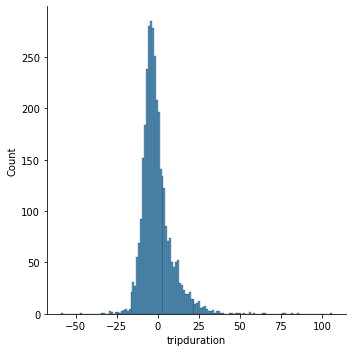

In [36]:
# Histogram of Forest errors
forest_predictions = forest.predict(X_test)
forest_error = y_test - forest_predictions
sns.displot(forest_error)

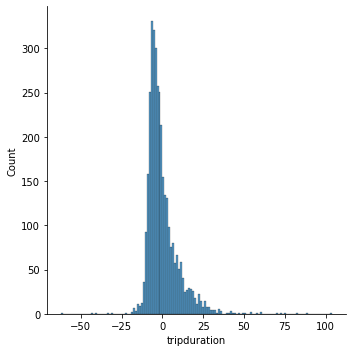

In [37]:
# Histogram of Gradient errors
gb_predictions = GBr.predict(X_test)
gb_error = y_test - gb_predictions
sns.displot(gb_error)

In [38]:
print('Forest MSE:', mean_squared_error(y_test, forest_predictions))
print('Forest RMSE:', np.sqrt(mean_squared_error(y_test, forest_predictions)))

Forest MSE: 95.53911786195526
Forest RMSE: 9.774411381866187


In [39]:
print('Gradient MSE:', mean_squared_error(y_test, gb_predictions))
print('Gradient RMSE:', np.sqrt(mean_squared_error(y_test, gb_predictions)))

Gradient MSE: 95.40356356758092
Gradient RMSE: 9.767474779469918


In [40]:
print('Forest MAE:', mean_absolute_error(y_test, forest_predictions))

Forest MAE: 6.7832757071865455


In [41]:
print('Gradient MAE:',mean_absolute_error(y_test, gb_predictions))

Gradient MAE: 6.814705055271847


## Save the Model

In [42]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [43]:
import joblib

In [44]:
# Save the models to Drive
 
joblib.dump(forest,'/content/drive/MyDrive/Projects/BigQuery/forest.joblib')
joblib.dump(GBr,'/content/drive/MyDrive/Projects/BigQuery/GBr.joblib')

['/content/drive/MyDrive/Projects/BigQuery/GBr.joblib']

# Predicting on brand new data

In [45]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [46]:
import joblib
import pandas as pd
import numpy as np

In [47]:
# Load the models
loaded_rf = joblib.load('/content/drive/MyDrive/Projects/BigQuery/forest.joblib')
 
# Load the model
loaded_GBr = joblib.load('/content/drive/MyDrive/Projects/BigQuery/GBr.joblib')

In [48]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [49]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [50]:
project_id = 'sixth-flag-316719'

In [51]:
# Create a sampled DataFrame for predictions on Apr-May 2018
 
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)
 
sample_count = 40000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]
 
evaluation_table = client.query('''
  SELECT
    tripduration/60 tripduration, 
                        starttime,
                        stoptime,
                        start_station_id,
                        start_station_name, 
                        end_station_id,
                        end_station_name,
                        usertype,
                        birth_year, 
                        gender
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    (EXTRACT (YEAR FROM starttime)=2018 AND 
      (EXTRACT (MONTH FROM starttime)=04 OR 
        EXTRACT (MONTH FROM starttime)=05))
    AND (tripduration>=3*60 AND tripduration<=2*60*60) # Trip duration between 3 minutes and 2 hours
    AND  birth_year is not NULL
    AND birth_year < 2007
    AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
# Pre-process dates and time
 
evaluation_table['Hour'] = evaluation_table['starttime'].apply(lambda time: time.hour)
evaluation_table['Month'] = evaluation_table['starttime'].apply(lambda time: time.month)
evaluation_table['Day of Week'] = evaluation_table['starttime'].apply( lambda time: time.dayofweek)
 
# Since the data consists of start time and duration, start and end time stamps can be dropped
 
evaluation_table = evaluation_table.drop(['starttime', 'stoptime'], axis=1)
 
# Map user type to 0 for customer or 1 for subscriber
 
evaluation_table['usertype'] = evaluation_table['usertype'].map({'Customer':0, 'Subscriber':1})
 
# Map gender to numeric variables
 
evaluation_table['gender'] = evaluation_table['gender'].map({'male':0, 'female':1, 'unknown':2})
 
# drop additional unnecessary variables
 
evaluation_table = evaluation_table.drop(['start_station_name', 'end_station_name', 'tripduration'], axis=1) # Trip duration is the y-variable
 
evaluation_table.dropna(inplace=True)

In [52]:
evaluation_table.head(3)

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
0,3123,3524,1,1996,0,14,5,0
1,337,236,1,1952,1,16,4,4
2,368,432,1,1954,0,8,5,6


In [53]:
evaluation_table.describe()

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
count,2007.000000,2007.00000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000
mean,1565.313901,1540.55157,0.887394,1978.359243,0.414051,13.971101,4.568012,2.796213
std,1432.400707,1416.92442,0.316189,11.869051,0.658151,4.806335,0.495476,1.843267
min,72.000000,72.00000,0.000000,1900.000000,0.000000,0.000000,4.000000,0.000000
25%,382.000000,379.00000,1.000000,1969.000000,0.000000,10.000000,4.000000,1.000000
50%,502.000000,508.00000,1.000000,1980.000000,0.000000,15.000000,5.000000,3.000000
75%,3241.000000,3226.00000,1.000000,1988.000000,1.000000,18.000000,5.000000,4.000000
max,3686.000000,3684.00000,1.000000,2001.000000,2.000000,23.000000,5.000000,6.000000


In [54]:
RFpredictions = loaded_rf.predict(evaluation_table)
RFpredictions = pd.DataFrame(RFpredictions)

In [55]:
GBpredictions = loaded_GBr.predict(evaluation_table)
GBpredictions = pd.DataFrame(GBpredictions)

In [56]:
evaluation_table['RF_predicted duration'] = RFpredictions

In [57]:
evaluation_table['GB_predicted duration'] = GBpredictions

In [58]:
evaluation_table.head(15)

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week,RF_predicted duration,GB_predicted duration
0,3123,3524,1,1996,0,14,5,0,14.956167,15.407364
1,337,236,1,1952,1,16,4,4,12.202167,13.603850
2,368,432,1,1954,0,8,5,6,12.570667,13.518996
3,2008,2009,1,1954,0,10,4,0,12.904667,11.521723
4,495,423,1,1956,0,19,4,5,15.781833,12.053281
5,361,340,1,1956,0,17,5,0,14.064833,12.395789
6,315,236,1,1957,0,16,4,0,14.609833,11.819880
7,328,72,1,1959,1,20,4,0,24.595500,26.819277
8,3467,249,1,1959,0,19,5,2,18.340500,14.490455
9,363,504,1,1960,1,17,5,1,13.763167,14.231502


# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
 
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
mmap = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
gmap = {0:'Male', 1:'Female', 2:'Unknown'}
evaluation_table.sort_values('Day of Week', inplace=True)
evaluation_table['Day of Week'] = evaluation_table['Day of Week'].map(dmap)
evaluation_table['Month'] = evaluation_table['Month'].map(mmap)
evaluation_table['gender'] = evaluation_table['gender'].map(gmap)

In [ ]:
# Stacked histogram showing Gradient predicted duration based on the gender column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']==0]['GB_predicted duration'], name="male trip duration"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']==1]['GB_predicted duration'], name="female trip duration"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']==2]['GB_predicted duration'], name="unkown trip duration"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing predicted duration based on the gender column', xaxis_title='Predicted trip duration') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Stacked histogram showing Gradient predicted durations based on the usertype column
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=evaluation_table[evaluation_table['usertype']==0]['GB_predicted duration'], name="Customer"))
fig2.add_trace(go.Histogram(x=evaluation_table[evaluation_table['usertype']==1]['GB_predicted duration'], name="Subscriber"))
fig2.update_layout(barmode='overlay', title='Stacked histogram showing predicted durations based on the usertype column', xaxis_title='Predicted trip duration') # Overlay histograms
fig2.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Bar graph of trip counts by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['GB_predicted duration'].count(), name="Trip counts by week day"))
fig3.update_layout(title='Trip counts by week day', xaxis_title='Day of Week')
 
# Bar graph of average predicted trip length by week day
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['GB_predicted duration'].mean(), name="Average predicted trip duration by week day"))
fig4.update_layout(title='Mean predicted trip length by week day', xaxis_title='Day of Week')
 
# Bar graph of average predicted trip length by gender
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=evaluation_table['gender'].unique(), y=evaluation_table.groupby('gender')['GB_predicted duration'].mean(), name="Average predicted trip duration by gender"))
fig5.update_layout(title='Mean trip length by gender', xaxis_title='Gender')

In [60]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in evaluation_table.columns],
        data=evaluation_table.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [61]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [62]:
public_url = ngrok.connect(addr = '8050')

In [63]:
#ngrok url link
 
public_url

<NgrokTunnel: "http://4bda-34-125-11-151.ngrok.io" -> "http://localhost:8050">

In [64]:
ngrok.kill()